# Simulation Objective and Background

The tasks under consideration are not inherently time-intensive; however, ensuring clear assignment of responsibilities is critical to the company’s ability to operate efficiently. A well-defined framework of responsibility supports routine execution, avoids overcomplicating simple processes, and ensures that tasks are appropriately distributed. This helps prevent overburdening any individual while ensuring someone is always available to handle these minor activities effectively.

Our objective is to provide the process owner with actionable insights and guidelines for setting up responsibilities. To achieve this, we will simulate various scenarios to evaluate:

How long a responsible person should be engaged with these activities.
How many people should share responsibility for these tasks.
To begin, we analyze the current state of the process, including the roles and users involved, to understand how responsibilities are presently handled.

# Assumptions: 
The tasks in question are minor and generally consist of activities requiring minimal effort, often no more than a single click.
We estimate the duration of each task to be approximately 5 minutes, including preparation time (e.g., getting into the correct mindset, starting the required software, and locating necessary information such as order numbers or documents).




# Restrictions
Grouped Execution:

We currently lack sufficient data to account for the effects of grouped execution. For example:
If an activity like removing a payment block requires manual intervention, grouped execution may significantly reduce the overall effort. In such cases, setup activities like starting the software or navigating to the relevant interface are only required once for a batch of tasks.
This simplification may lead to overestimating the cumulative workload in scenarios where grouped execution is feasible.
Limited Domain-Specific Adjustments:

Without further collaboration or input from domain experts, the assumptions regarding task durations and their dependencies cannot be refined beyond this general approximation.

In [48]:
import pandas as pd
import numpy as np
import pm4py
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [4]:
log = pm4py.read_xes("./3_waymatch_invoicebeforeGR_StandardPO.xes")

c:\Users\jojow\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 178600/178600 [01:39<00:00, 1795.74it/s]


In [347]:
manual_activities = log[~log["org:resource"].str.startswith("batch")]
grouped_data = (
    manual_activities.groupby(["org:resource", "concept:name", "case:Spend area text"])
    .size()
    .unstack(fill_value=0)
)
grouped_data

case:Spend area text                           Other  Packaging  Sales
org:resource concept:name                                             
user_001     Cancel Invoice Receipt              264         95    274
             Cancel Subsequent Invoice            45         30     71
             Clear Invoice                        83         14     58
             Record Invoice Receipt             8565       7621  10936
             Record Subsequent Invoice            18          8      5
...                                              ...        ...    ...
user_591     Create Purchase Order Item            0         11      0
             Create Purchase Requisition Item      0          1      0
             Delete Purchase Order Item            0          6      0
user_593     Create Purchase Requisition Item      1          0      0
user_598     Create Purchase Requisition Item      5          0      0

[1357 rows x 3 columns]

In [344]:
log["concept:name"].unique()

array(['Create Purchase Order Item', 'Receive Order Confirmation',
       'Record Goods Receipt', 'Record Invoice Receipt', 'Clear Invoice',
       'Change Quantity', 'Change Delivery Indicator',
       'Cancel Subsequent Invoice', 'Remove Payment Block',
       'Change Price', 'Cancel Invoice Receipt',
       'Delete Purchase Order Item', 'Reactivate Purchase Order Item',
       'Update Order Confirmation', 'Block Purchase Order Item',
       'Change Approval for Purchase Order', 'Release Purchase Order',
       'Cancel Goods Receipt', 'Record Subsequent Invoice',
       'Create Purchase Requisition Item', 'Set Payment Block',
       'Change Storage Location', 'Change Currency',
       'Change payment term', 'Release Purchase Requisition'],
      dtype=object)

First, to enable simulation in Apromore, we generated approximate end times for events in the log. Durations were calculated by introducing random variability to a baseline assumption of 5 minutes, which reflects our estimation of the time typically required for the types of tasks at hand. Approximately 2% of events were assigned significantly longer durations, modeled as a normal distribution with a mean of 60 minutes, to account for rare cases involving complexity, delays, or external dependencies.

This approach is rooted in the nature of the activities in the event log, which primarily include transactional or administrative tasks such as creating purchase orders, recording receipts, or clearing invoices. These tasks are generally brief and align well with the assumed 5-minute duration for most cases. While the generated durations are synthetic and intended for demonstration purposes, they likely represent realistic execution times for such processes. Further refinement through domain expertise could improve the accuracy of these assumptions and provide more actionable insights for the process owner.

In [357]:
log.columns

Index(['User', 'org:resource', 'concept:name', 'Cumulative net worth (EUR)',
       'time:timestamp', 'case:Spend area text', 'case:Company',
       'case:Document Type', 'case:Sub spend area text',
       'case:Purchasing Document', 'case:Purch. Doc. Category name',
       'case:Vendor', 'case:Item Type', 'case:Item Category',
       'case:Spend classification text', 'case:Source', 'case:Name',
       'case:GR-Based Inv. Verif.', 'case:Item', 'case:concept:name',
       'case:Goods Receipt'],
      dtype='object')

In [366]:
log.columns

Index(['User', 'org:resource', 'concept:name', 'Cumulative net worth (EUR)',
       'time:timestamp', 'case:Spend area text', 'case:Company',
       'case:Document Type', 'case:Sub spend area text',
       'case:Purchasing Document', 'case:Purch. Doc. Category name',
       'case:Vendor', 'case:Item Type', 'case:Item Category',
       'case:Spend classification text', 'case:Source', 'case:Name',
       'case:GR-Based Inv. Verif.', 'case:Item', 'case:concept:name',
       'case:Goods Receipt'],
      dtype='object')

In [368]:
np.random.seed(42)

log2 = log.copy()
# event_log = pm4py.convert_to_event_log(log)

duration_minutes = 
log2["time:complete"] = log2["time:timestamp"] + pd.to_timedelta(max(
    np.random.normal(loc=5, scale=1),
    max(1, np.random.choice([0, np.random.normal(60, 10)], p=[0.98, 0.02]))
), unit="m")

log2.to_csv("simulation.csv", index=False)
#pm4py.write_xes(log2, "simulation_with_start_complete.xes")

KeyboardInterrupt: 

In [358]:
simulation_log = log.copy()

np.random.seed(42)

simulation_log["time:complete"] = log["time:timestamp"] + pd.Timedelta(
    minutes=max(
        np.random.normal(loc=5, scale=1),
        max(1, np.random.choice([0, np.random.normal(60, 10)], p=[0.98, 0.02])),
    )
)

print(simulation_log[["time:timestamp", "time:complete"]].head())
pm4py.write_xes(simulation_log, "simulation.xes")

             time:timestamp                       time:complete
0 2018-01-01 02:42:00+00:00 2018-01-01 02:47:29.802849180+00:00
1 2018-01-02 10:04:00+00:00 2018-01-02 10:09:29.802849180+00:00
2 2018-01-05 12:36:00+00:00 2018-01-05 12:41:29.802849180+00:00
3 2018-01-05 16:35:00+00:00 2018-01-05 16:40:29.802849180+00:00
5 2018-04-26 09:14:00+00:00 2018-04-26 09:19:29.802849180+00:00


exporting log, completed traces :: 100%|██████████| 178600/178600 [01:10<00:00, 2545.01it/s]


## Understanding Responsibilitys

First, we prepare the data for further analysis. In particular, we begin by anlyzing missing values for the responsible user.

In [84]:
log.columns

Index(['User', 'org:resource', 'concept:name', 'Cumulative net worth (EUR)',
       'time:timestamp', 'case:Spend area text', 'case:Company',
       'case:Document Type', 'case:Sub spend area text',
       'case:Purchasing Document', 'case:Purch. Doc. Category name',
       'case:Vendor', 'case:Item Type', 'case:Item Category',
       'case:Spend classification text', 'case:Source', 'case:Name',
       'case:GR-Based Inv. Verif.', 'case:Item', 'case:concept:name',
       'case:Goods Receipt'],
      dtype='object')

case:Spend area text       Other  Packaging  Sales
concept:name                                      
Clear Invoice               2411       2598   2439
Vendor creates debit memo   2089       1039   1694
Vendor creates invoice     46487      74190  54120
concept:name
Clear Invoice                177497
Vendor creates debit memo      4822
Vendor creates invoice       174797
dtype: int64
concept:name
Clear Invoice                0.041961
Vendor creates debit memo    1.000000
Vendor creates invoice       1.000000
dtype: float64


<Figure size 1200x600 with 0 Axes>

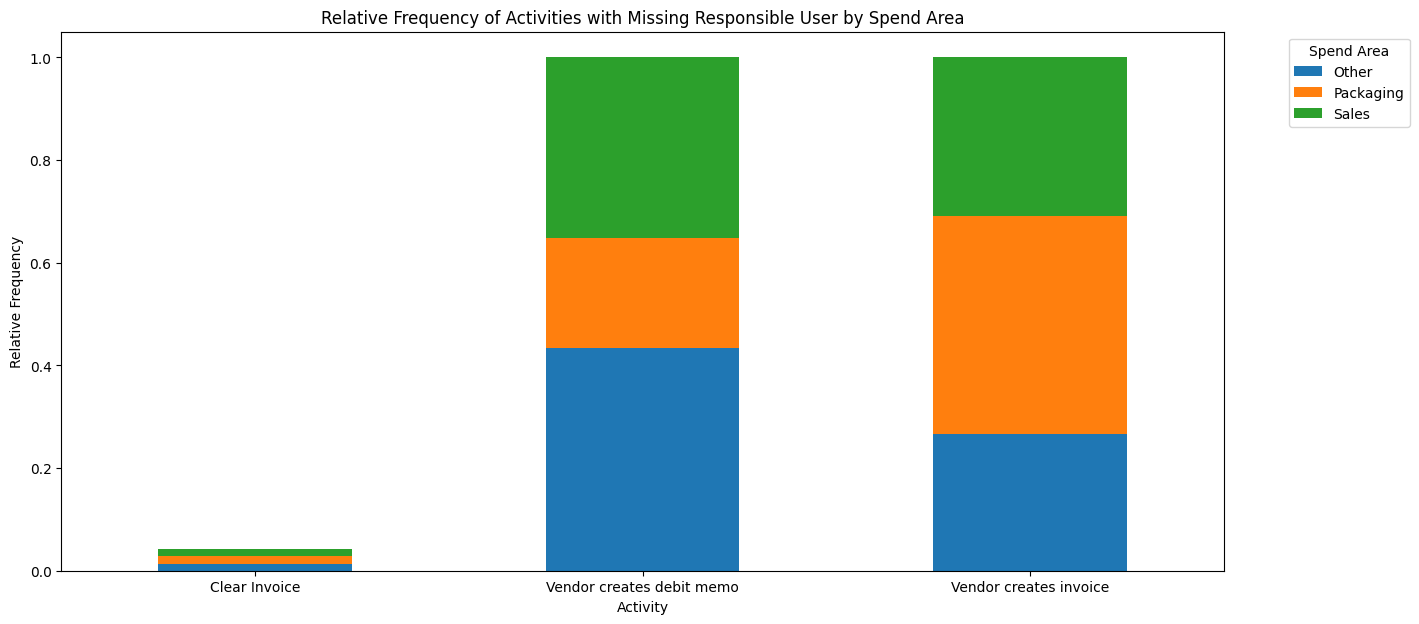

Number of cases affected by missing values in 'Clear Invoice': 7448
Number of cases in the log: 178600
Affected cases percent: 4.17%


In [103]:
# Replace 'NONE' with missing values
log.replace('NONE', None, inplace=True)

none_activities_spend_area = log[log['org:resource'].isnull()].pivot_table(
    index='concept:name', 
    columns='case:Spend area text', 
    aggfunc='size',
    fill_value=0
)
print(none_activities_spend_area)


total_occurrences_independent = log.pivot_table(
    index="concept:name", aggfunc="size", fill_value=0
).reindex(none_activities_spend_area.index)
print(total_occurrences_independent)

relative_none_activities_spend_area = none_activities_spend_area.div(
    total_occurrences_independent, axis=0
)

print(relative_none_activities_spend_area.sum(axis=1))

plt.figure(figsize=(12, 6))
ax = relative_none_activities_spend_area.plot(kind='bar', stacked=True, figsize=(15, 7))
plt.title('Relative Frequency of Activities with Missing Responsible User by Spend Area')
plt.xlabel('Activity')
plt.ylabel('Relative Frequency')
plt.legend(title='Spend Area', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0, ha='center')
plt.show()

# Calculate the number of cases affected by missing values in 'Clear Invoice'
affected_cases_clear_invoice = log[(log['concept:name'] == 'Clear Invoice') & (log['org:resource'].isnull())]['case:concept:name'].nunique()
print(f"Number of cases affected by missing values in 'Clear Invoice': {affected_cases_clear_invoice}")

# Calculate the number of cases in the log
number_of_cases = log['case:concept:name'].nunique()
print(f"Number of cases in the log: {number_of_cases}")

print(f'Affected cases percent: {round(affected_cases_clear_invoice / number_of_cases * 100, 2)}%')

The figure above summarizes the results. We can observe that user is always missing in the events *Vendor creates debit memo* and *Vendor creates invoice*. This makes sense, cince the resource is outside the company, its the vendor. In BPMN it would be best represented as a message received event. We keep this in mind for the simulation, possibly assigning a role vendor. For the analysis of responsibilities we can simply remove all events belonging to these activities.

However, in clear invoice a missing value for the user in 4.2% of cases is not as obvious to explain. Having our objective in mind, which is to explore responsibilities, we can simply remove the affected events, without any further implications. It's not necessary to remove the whole case, since these might provide valuable information in regard to responsibilities. 

In [110]:
log2 = log[~((log['concept:name'] == 'Clear Invoice') & (log['org:resource'].isnull()))]
print((len(log[log['concept:name'] == 'Clear Invoice']) - len(log2[log2['concept:name'] == 'Clear Invoice'])) / len(log[log['concept:name'] == 'Clear Invoice']))

log2 = log2[~(log2["concept:name"].isin(["Vendor creates invoice", "Vendor creates debit memo"]))]
print(log2['concept:name'].unique())

log = log2

0.041961272584888756
['Create Purchase Order Item' 'Receive Order Confirmation'
 'Record Goods Receipt' 'Record Invoice Receipt' 'Clear Invoice'
 'Change Quantity' 'Change Delivery Indicator' 'Cancel Subsequent Invoice'
 'Remove Payment Block' 'Change Price' 'Cancel Invoice Receipt'
 'Delete Purchase Order Item' 'Reactivate Purchase Order Item'
 'Update Order Confirmation' 'Block Purchase Order Item'
 'Change Approval for Purchase Order' 'Release Purchase Order'
 'Cancel Goods Receipt' 'Record Subsequent Invoice'
 'Create Purchase Requisition Item' 'Set Payment Block'
 'Change Storage Location' 'Change Currency' 'Change payment term'
 'Release Purchase Requisition']


Next, we aim to understand the current state of automation. What activities are automated and to what extend? Is there a difference across the spend areas? 

In [119]:
batch_log = log[log["org:resource"].str.startswith("batch")]
print(batch_log["org:resource"].unique())

['batch_03' 'batch_04' 'batch_02' 'batch_00' 'batch_05' 'batch_01'
 'batch_08' 'batch_09' 'batch_06' 'batch_12' 'batch_13' 'batch_07'
 'batch_11' 'batch_14' 'batch_16' 'batch_17' 'batch_19']


case:Spend area text              Other  Packaging  Sales
concept:name                                             
Cancel Goods Receipt                 74          0     28
Cancel Invoice Receipt                5         12      2
Change Quantity                       0          0      2
Create Purchase Order Item          759      10416    531
Create Purchase Requisition Item   1196       2207     66
Receive Order Confirmation            1       3767      0
Record Goods Receipt               8984       4119  11583
Record Invoice Receipt             1755       2927   2047
Record Subsequent Invoice             1          2      1
Release Purchase Requisition          0          1      0
Remove Payment Block               4199       4160   5373
Update Order Confirmation             0          4      0
concept:name
Cancel Goods Receipt                  1052
Cancel Invoice Receipt                4614
Change Quantity                      14577
Create Purchase Order Item          178600
Cre

<Figure size 1200x600 with 0 Axes>

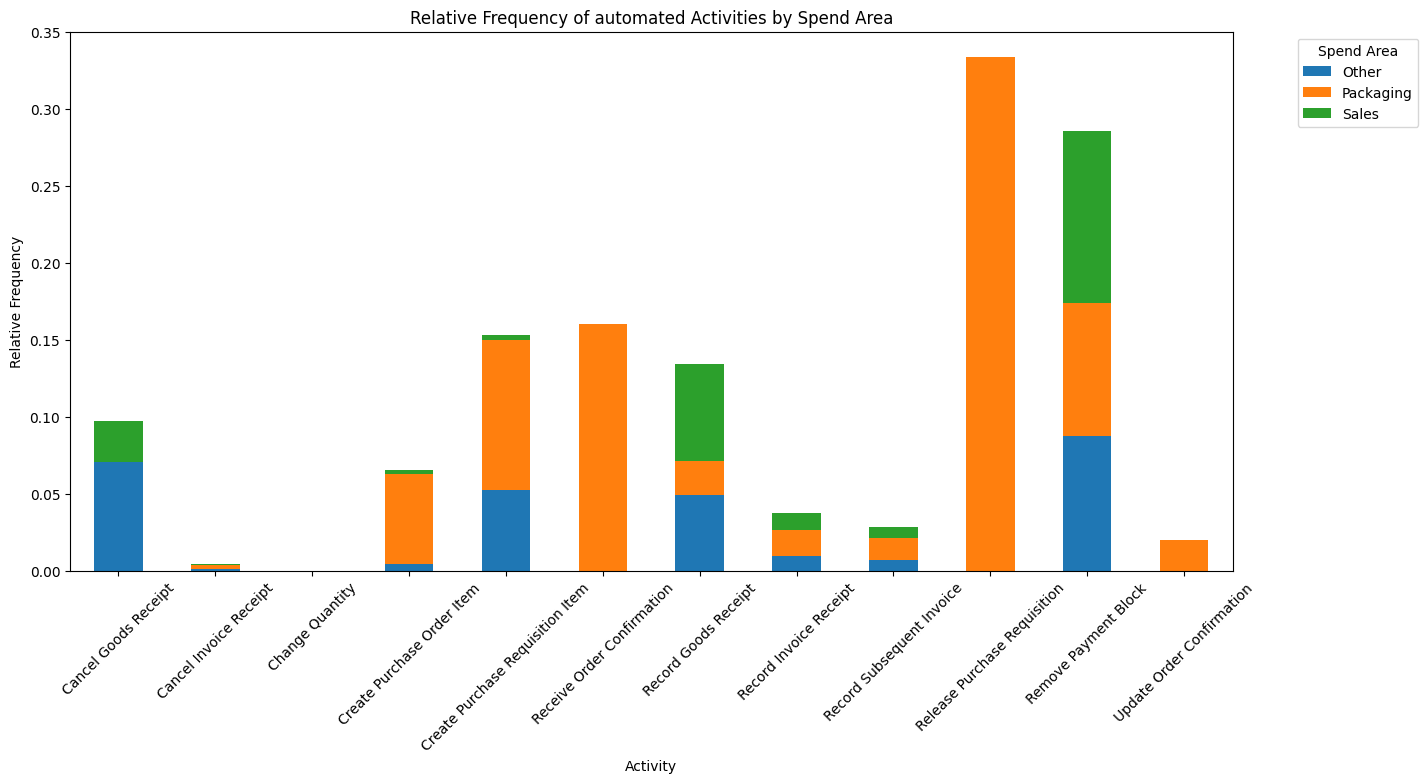

In [123]:
automated_activities = log[log["org:resource"].str.startswith("batch")]

automated_activities_spend_area = automated_activities.pivot_table(
    index="concept:name", columns="case:Spend area text", aggfunc="size", fill_value=0
)
print(automated_activities_spend_area)


total_occurrences_independent = log.pivot_table(
    index="concept:name", aggfunc="size", fill_value=0
).reindex(automated_activities_spend_area.index)
print(total_occurrences_independent)

relative_automated_activities_spend_area = automated_activities_spend_area.div(
    total_occurrences_independent, axis=0
)

print(relative_automated_activities_spend_area)

plt.figure(figsize=(12, 6))
ax = relative_automated_activities_spend_area.plot(
    kind="bar", stacked=True, figsize=(15, 7)
)
plt.title(
    "Relative Frequency of automated Activities by Spend Area"
)
plt.xlabel("Activity")
plt.ylabel("Relative Frequency")
plt.legend(title="Spend Area", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45, ha="center")
plt.show()

# Calculate the number of cases affected by missing values in 'Clear Invoice'
#affected_cases_clear_invoice = log[
#    (log["concept:name"] == "Clear Invoice") & (log["org:resource"].isnull())
#]["case:concept:name"].nunique()
#print(
#    f"Number of cases affected by missing values in 'Clear Invoice': {affected_cases_clear_invoice}"
#)
#
## Calculate the number of cases in the log
#number_of_cases = log["case:concept:name"].nunique()
#print(f"Number of cases in the log: {number_of_cases}")
#
#print(
#    f"Affected cases percent: {round(affected_cases_clear_invoice / number_of_cases * 100, 2)}%"
#)

Since none of the activities is fully automized we will assign the use our findings to  

When discovering roles, we face the following challenges. First, not all activities are happening with the same frequency, which makes it necessary to scale the data in a way that users who are only responsible for certain tasks which barely happen are discovered as arole. On the other hand just because a user did an activity once when his collegue was on vacation hes not responsible. 

We scale responsibilities by dividing the amount of times a user handled an activity by the total occurence of this activity. 

In [168]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd

# Create a user-spend area matrix
user_spend_area_matrix = log.pivot_table(
    index="org:resource", 
    columns="case:Spend area text", 
    aggfunc="size", 
    fill_value=0
)

# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(user_spend_area_matrix)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust n_clusters as needed
kmeans.fit(normalized_data)

# Assign cluster labels
user_spend_area_matrix["cluster"] = kmeans.labels_

# Print the resulting clusters
print(user_spend_area_matrix)

# Group by cluster labels
grouped = user_spend_area_matrix.groupby("cluster")

# Display users in each cluster
for cluster, group in grouped:
    print(f"Cluster {cluster}:")
    print(group.index.tolist())
    print("\n")

case:Spend area text  Other  Packaging  Sales  cluster
org:resource                                          
batch_00               2446       9504   2846        2
batch_01                 42         61     22        0
batch_02               6459       4064   6087        2
batch_03               3094       5640   4496        2
batch_04                 14       2047      0        0
...                     ...        ...    ...      ...
user_585                  2          0      0        0
user_589                  1          0      0        0
user_591                  0         20      0        0
user_593                  1          0      0        0
user_598                  5          0      0        0

[549 rows x 4 columns]
Cluster 0:
['batch_01', 'batch_04', 'batch_05', 'batch_06', 'batch_07', 'batch_08', 'batch_09', 'batch_11', 'batch_12', 'batch_13', 'batch_14', 'batch_16', 'batch_17', 'batch_19', 'user_004', 'user_007', 'user_008', 'user_011', 'user_018', 'user_023', 'user_024

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1843093939.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


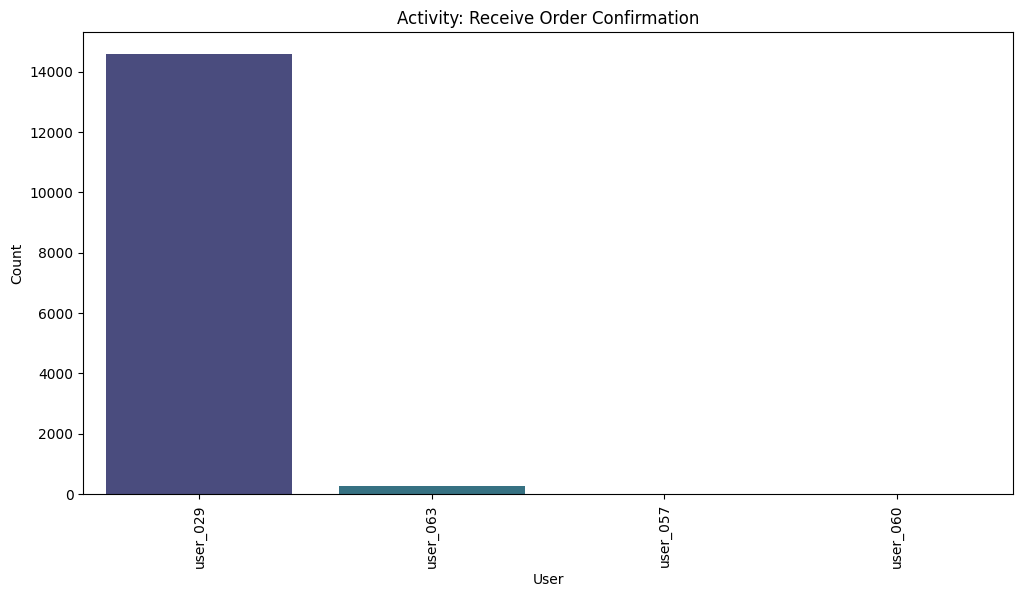

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1843093939.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


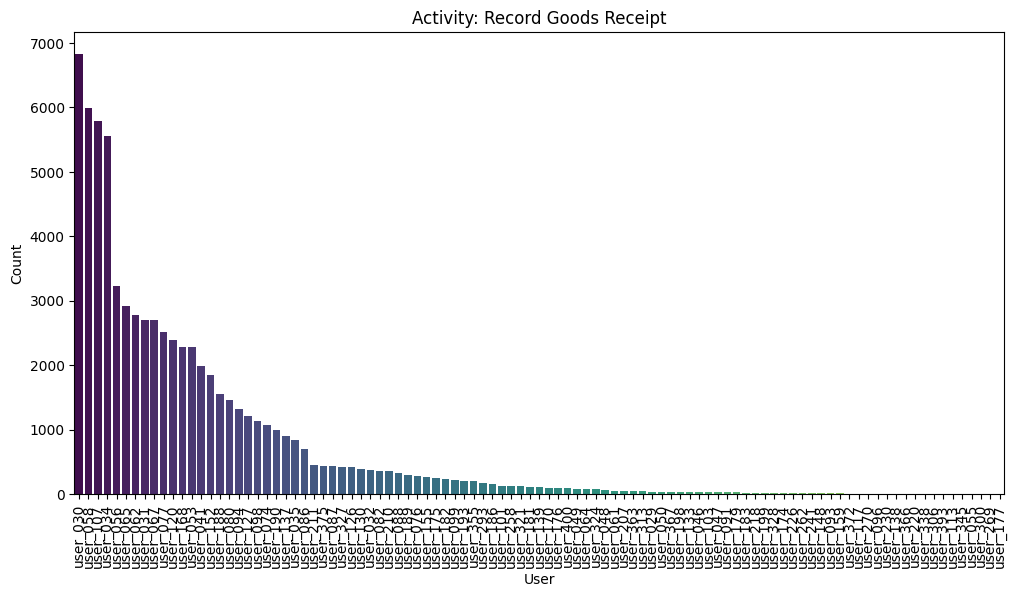

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1843093939.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


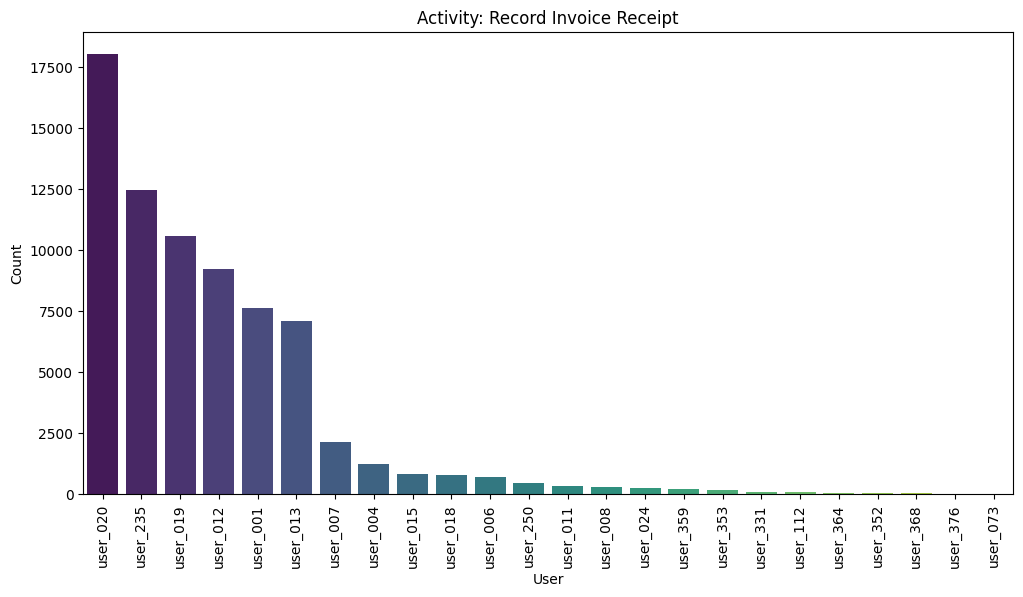

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1843093939.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


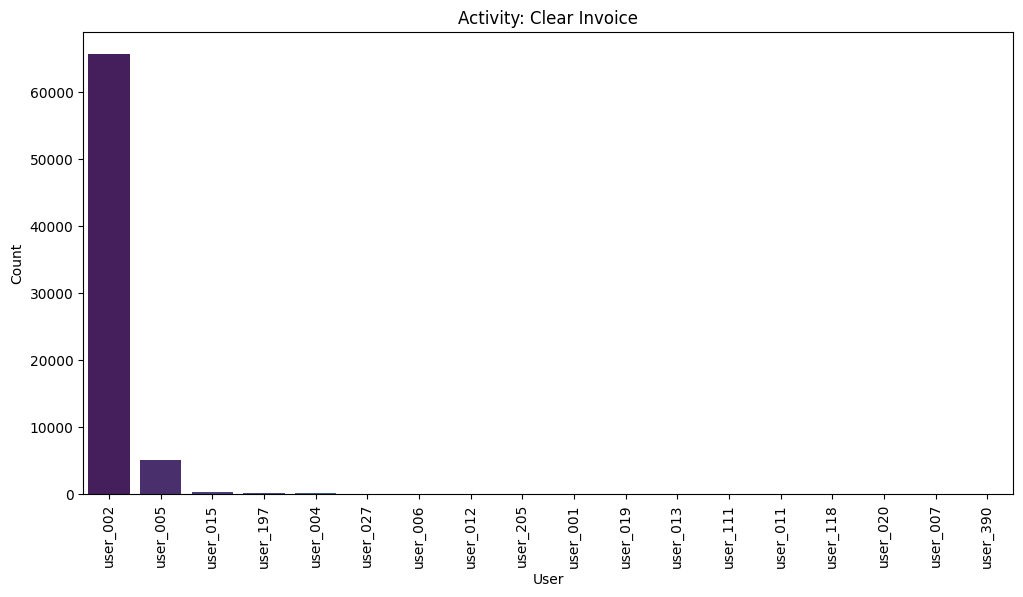

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1843093939.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


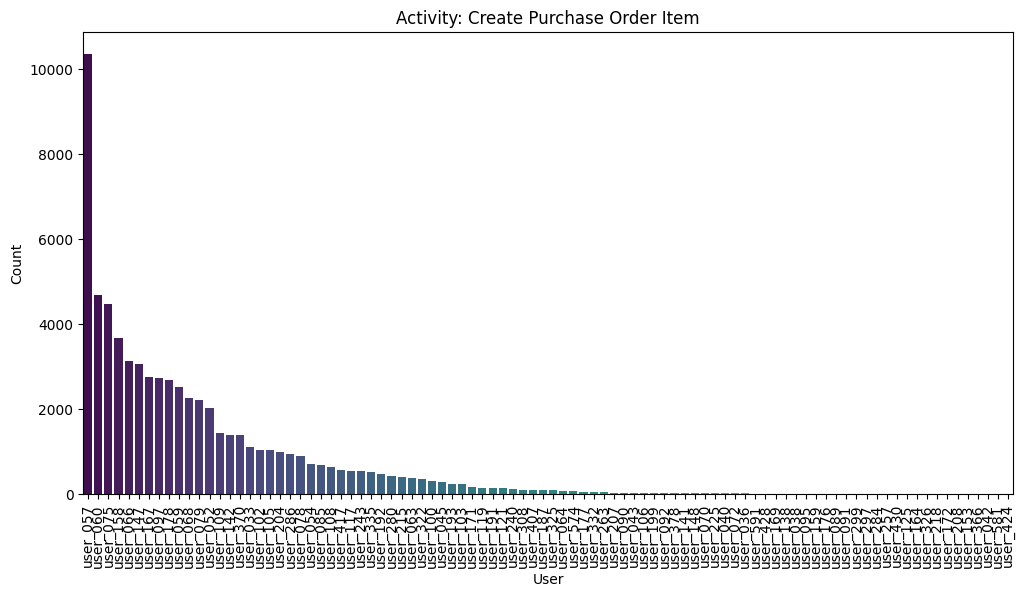

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1843093939.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


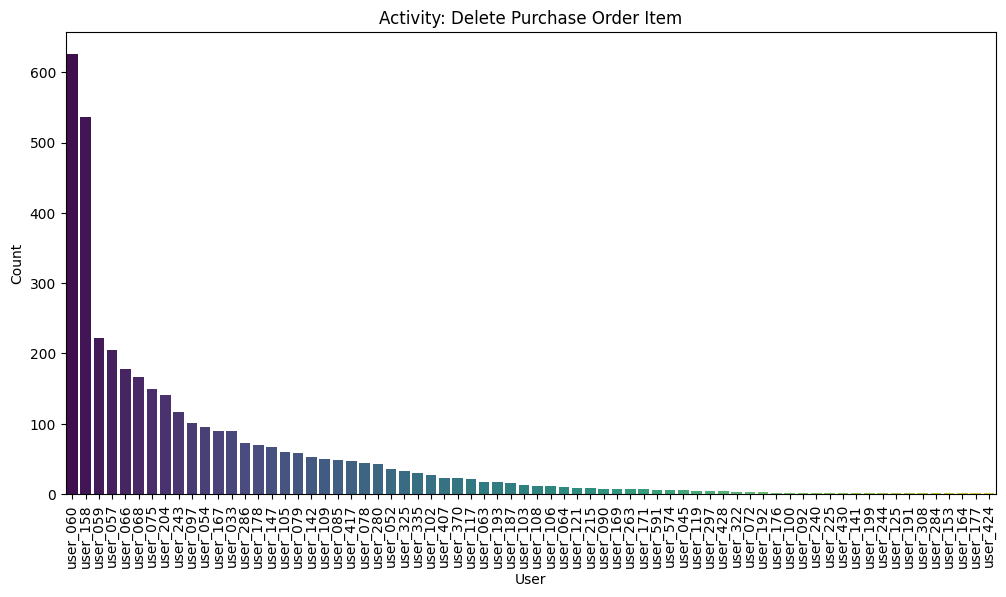

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1843093939.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


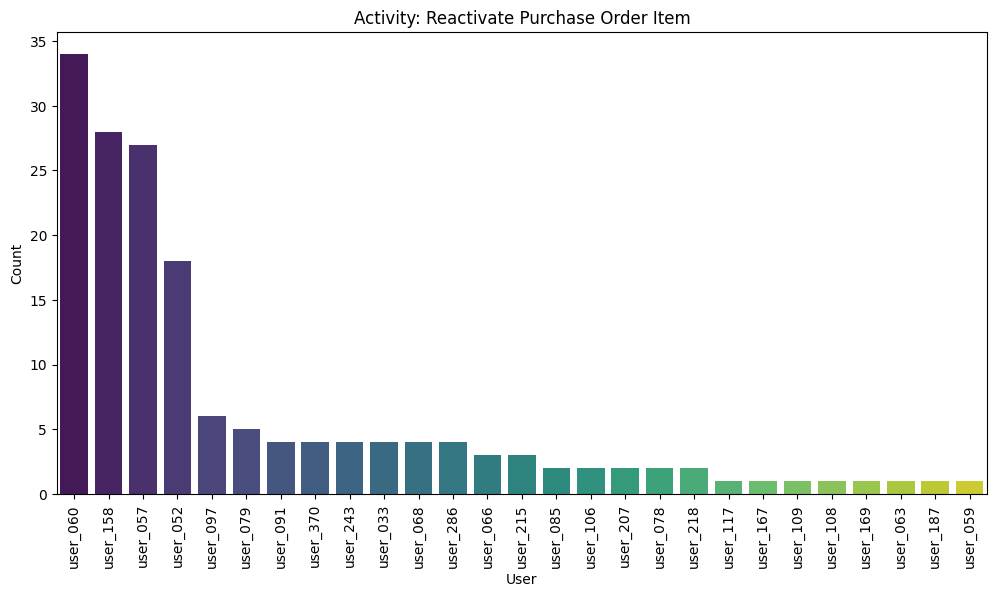

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1843093939.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


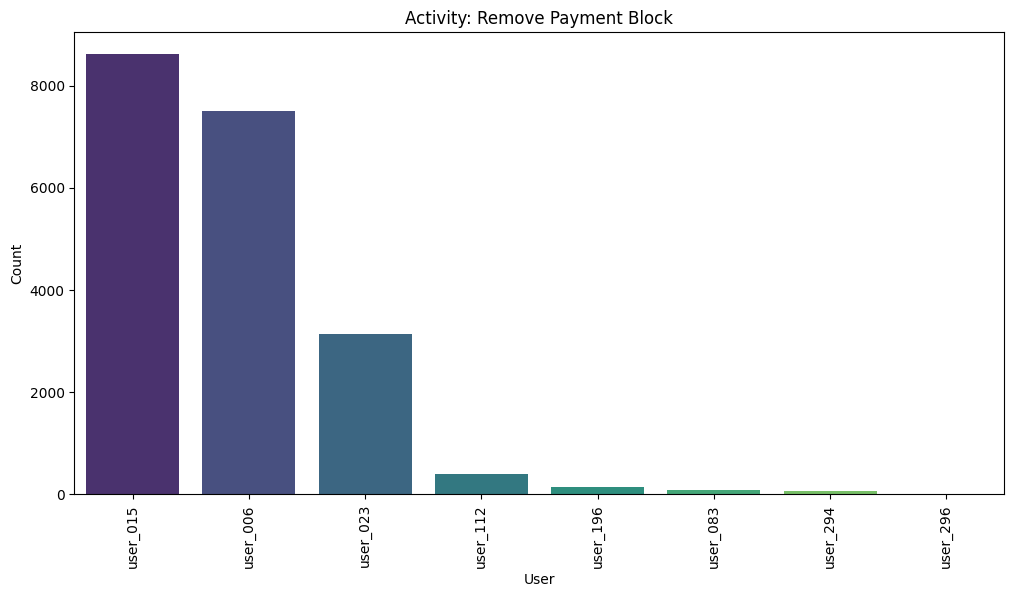

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1843093939.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


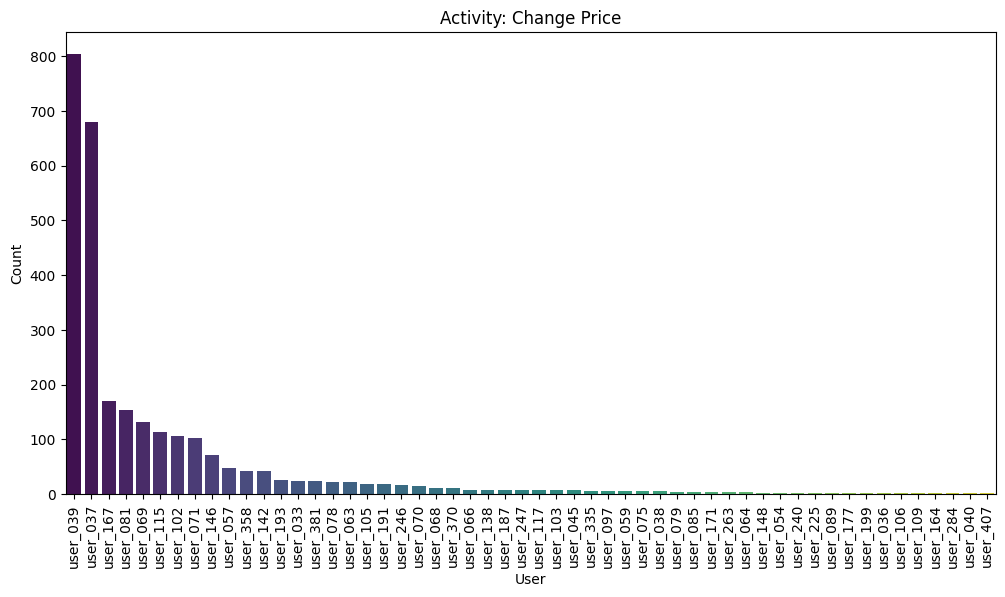

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1843093939.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


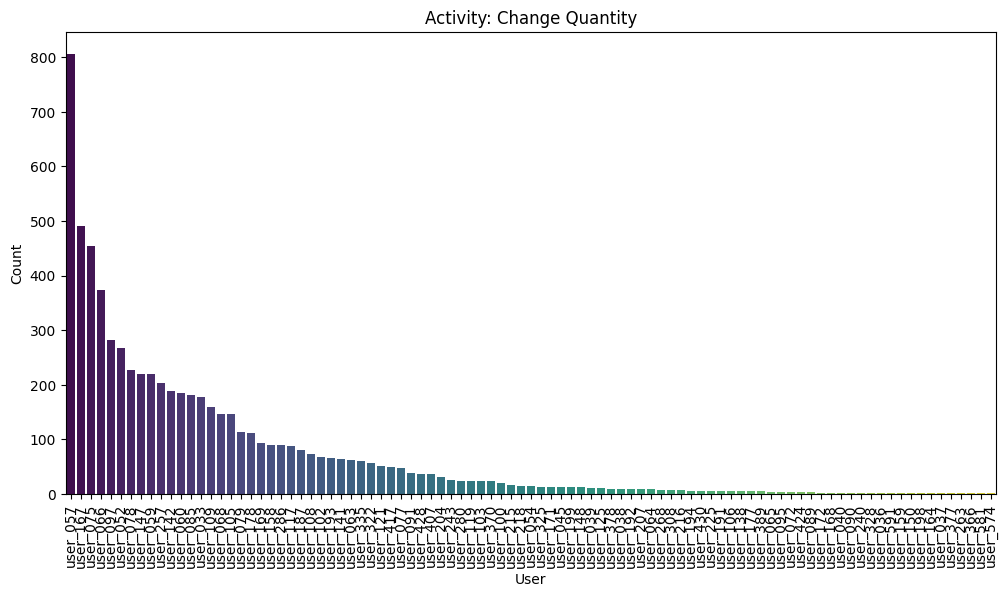

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1843093939.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


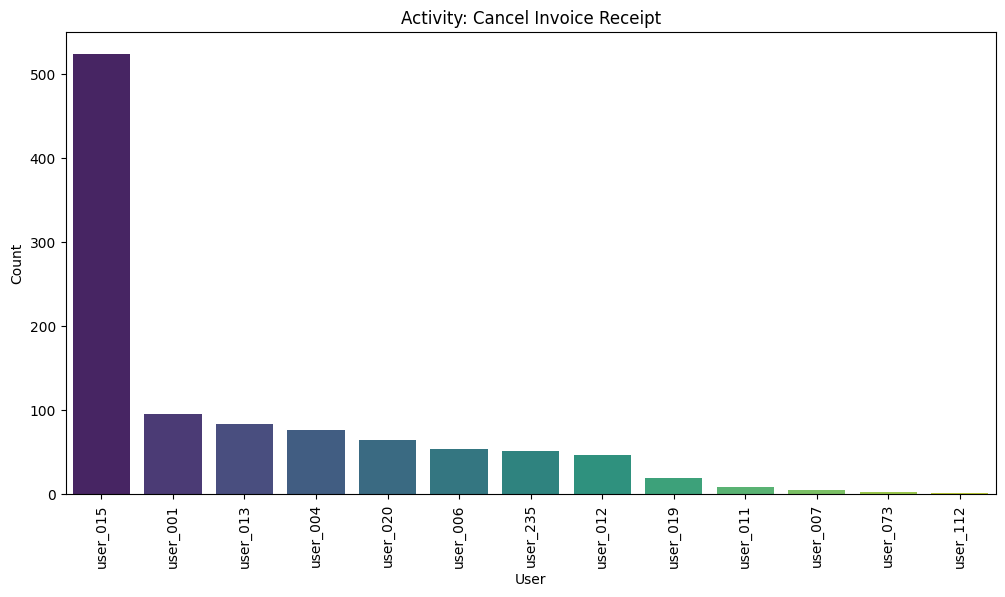

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1843093939.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


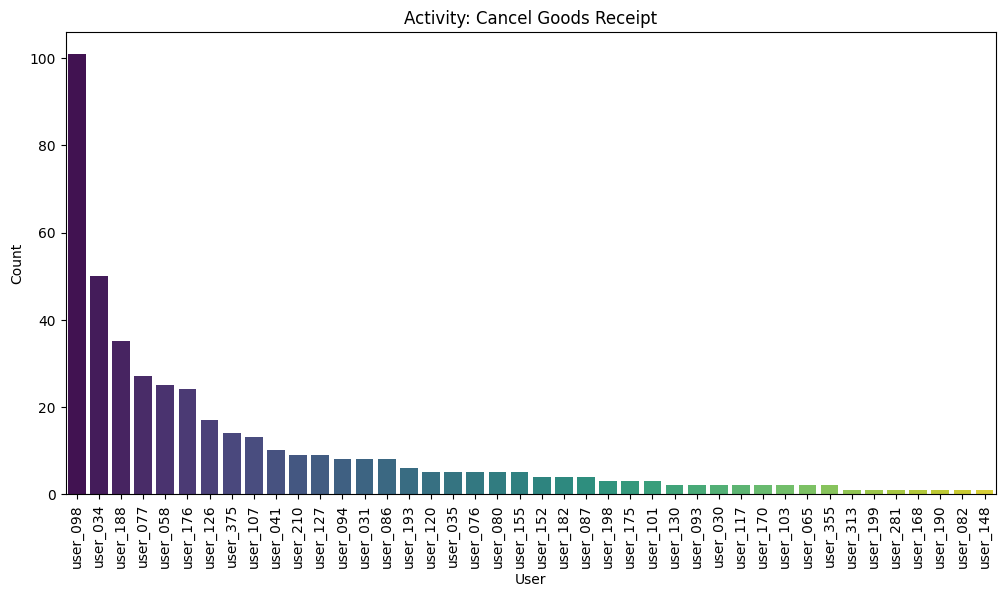

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1843093939.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


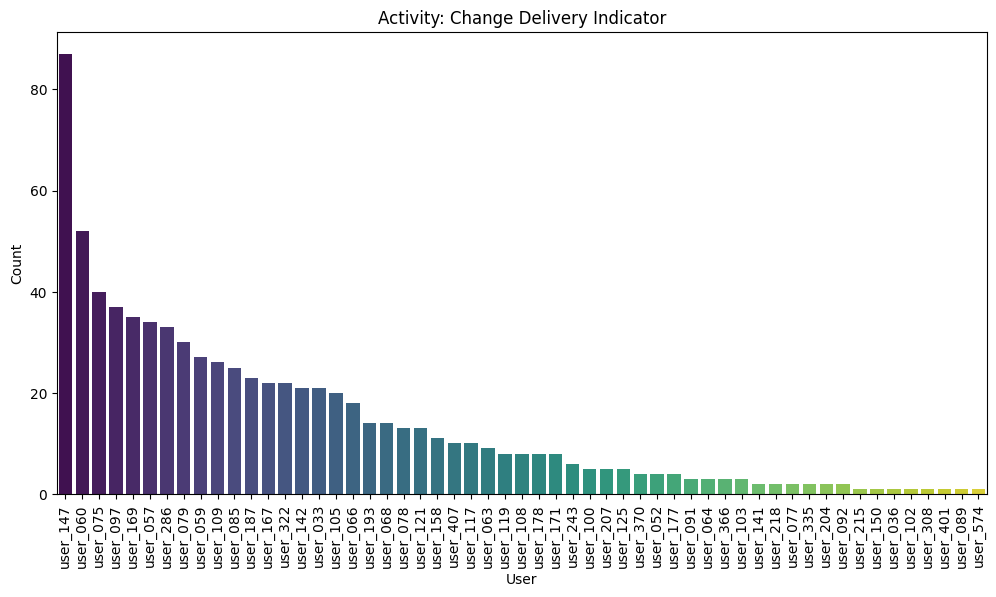

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1843093939.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


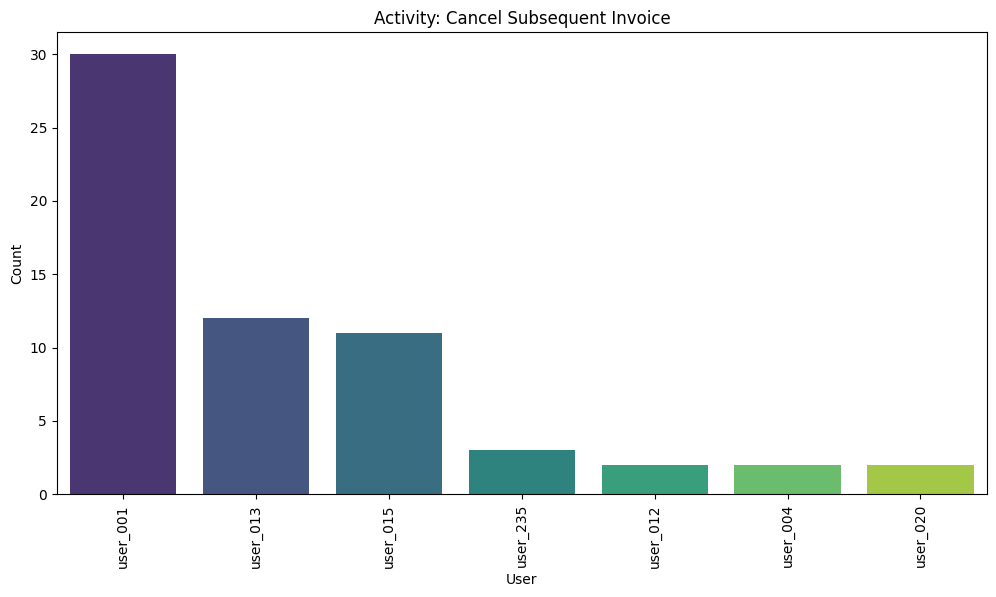

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1843093939.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


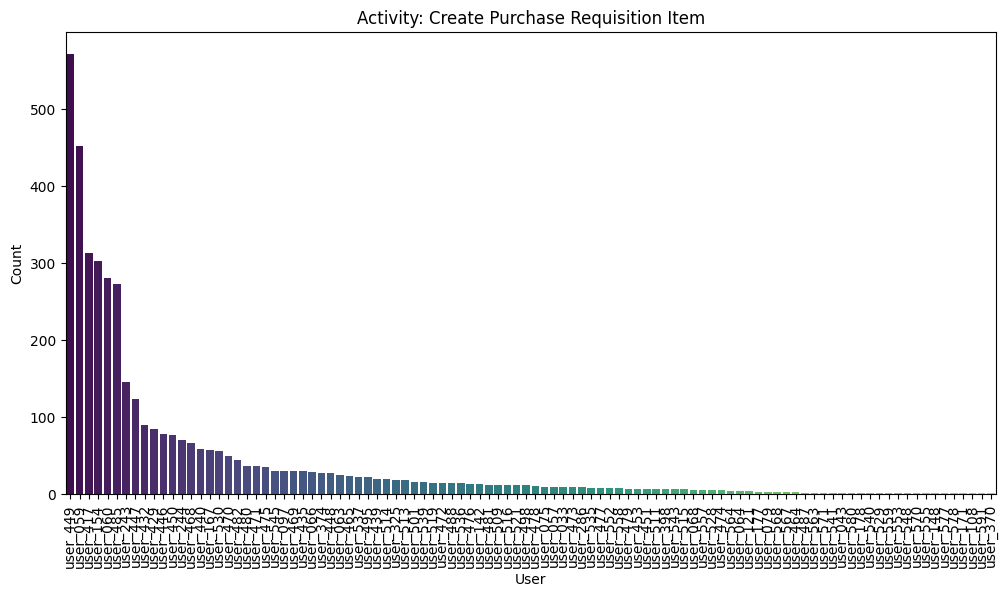

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1843093939.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


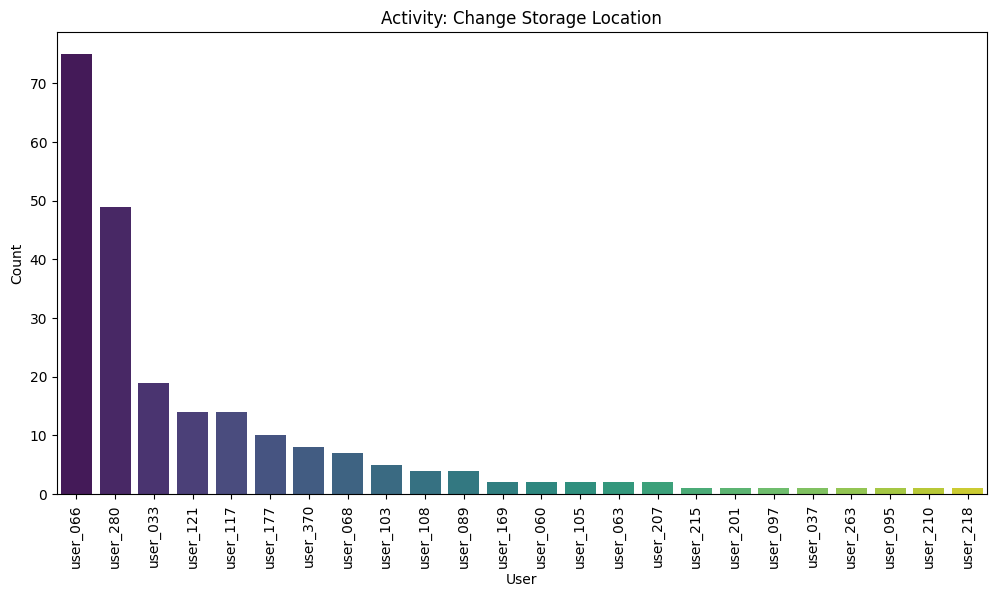

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1843093939.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


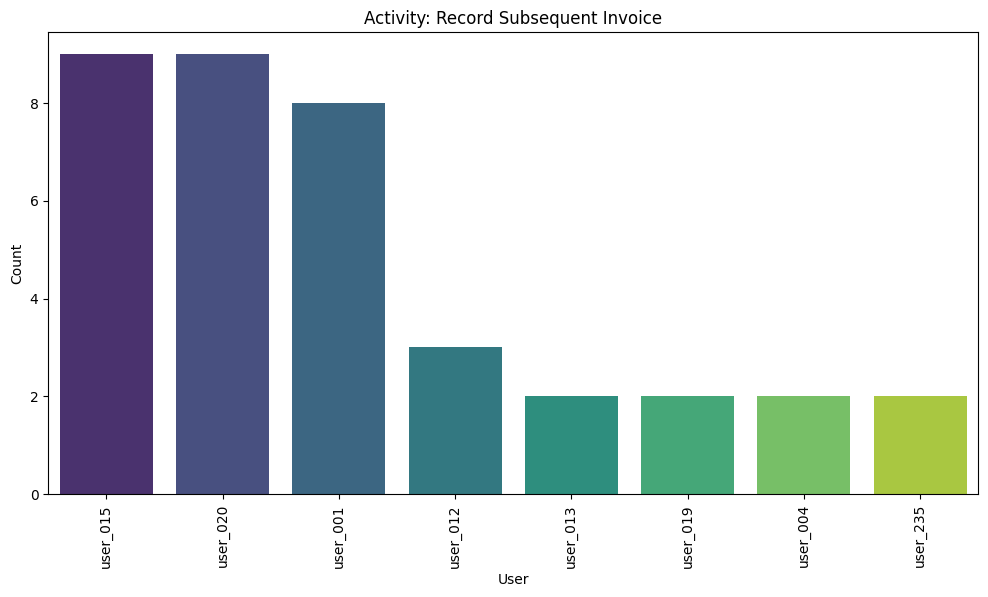

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1843093939.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


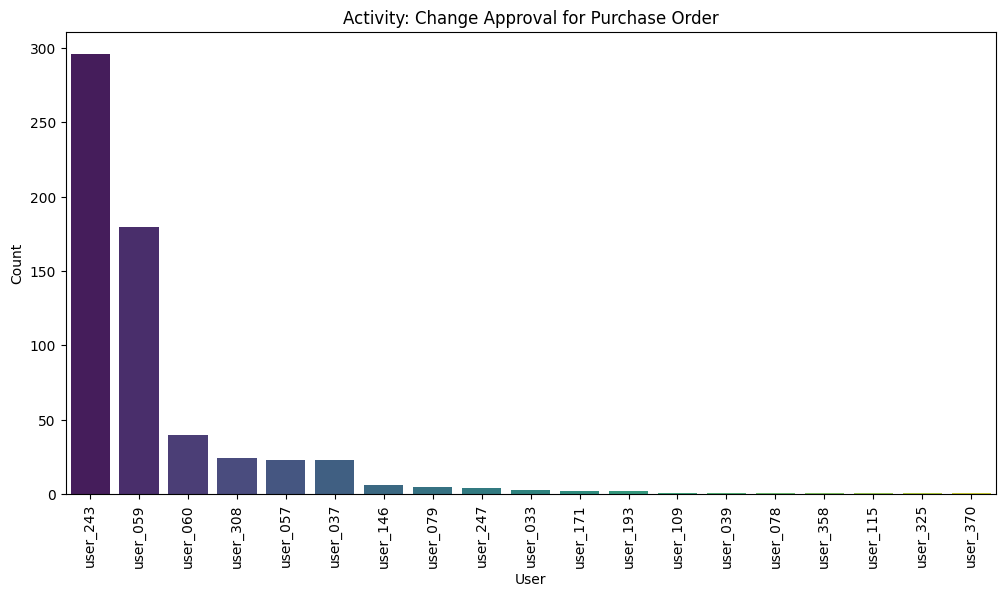

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1843093939.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


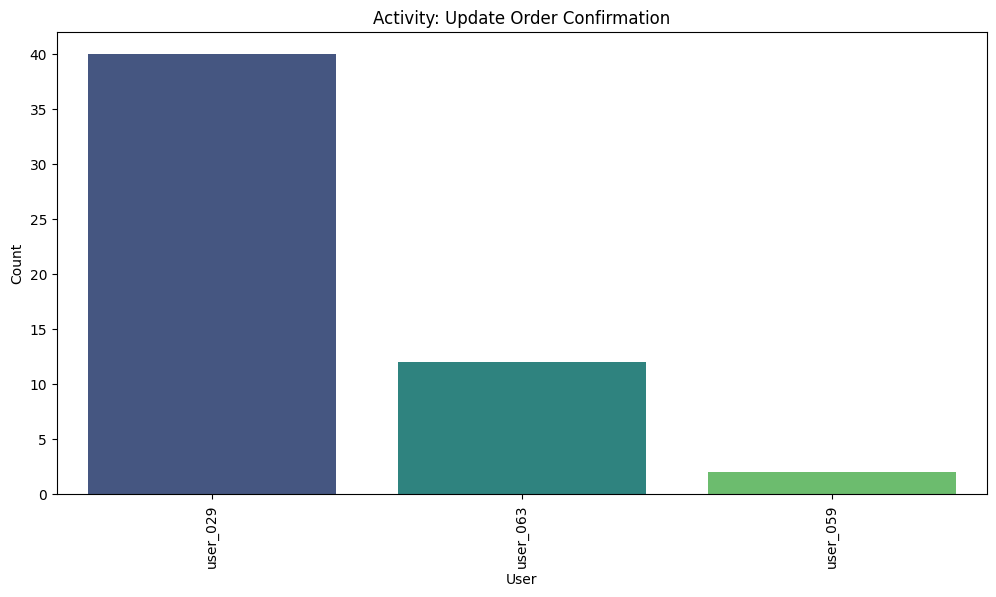

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1843093939.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


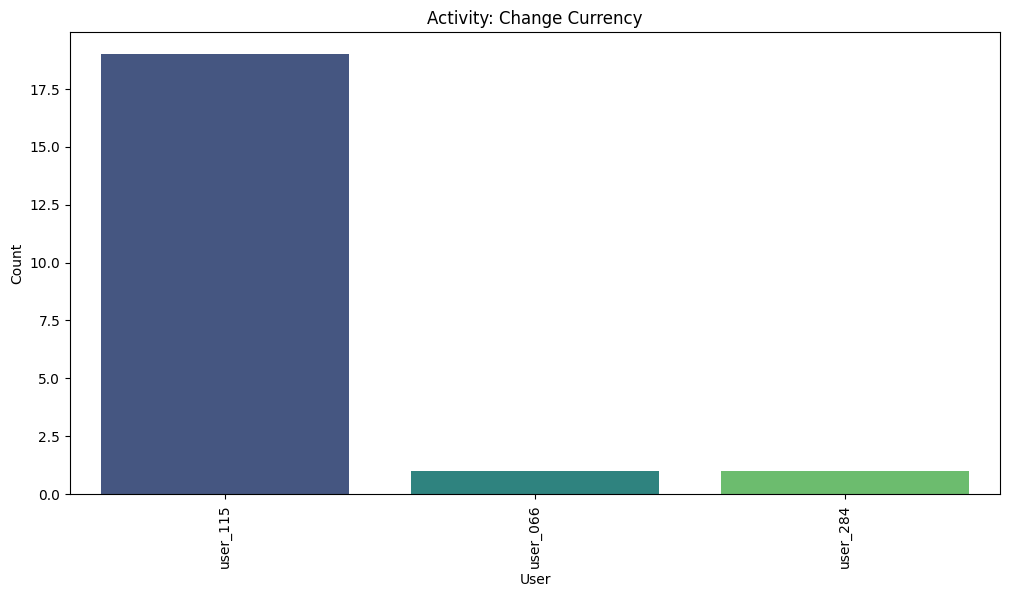

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1843093939.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


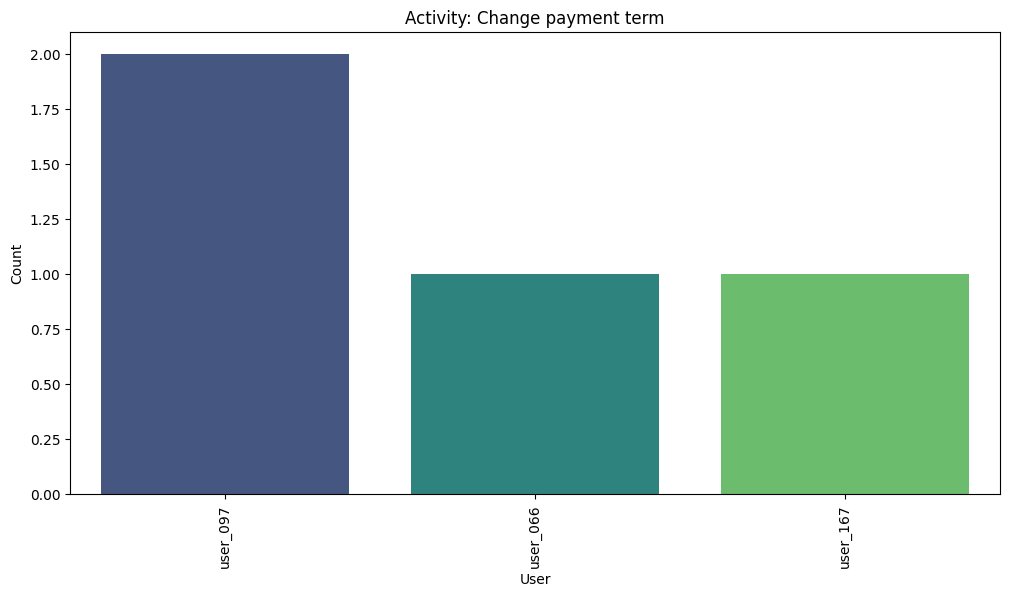

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1843093939.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


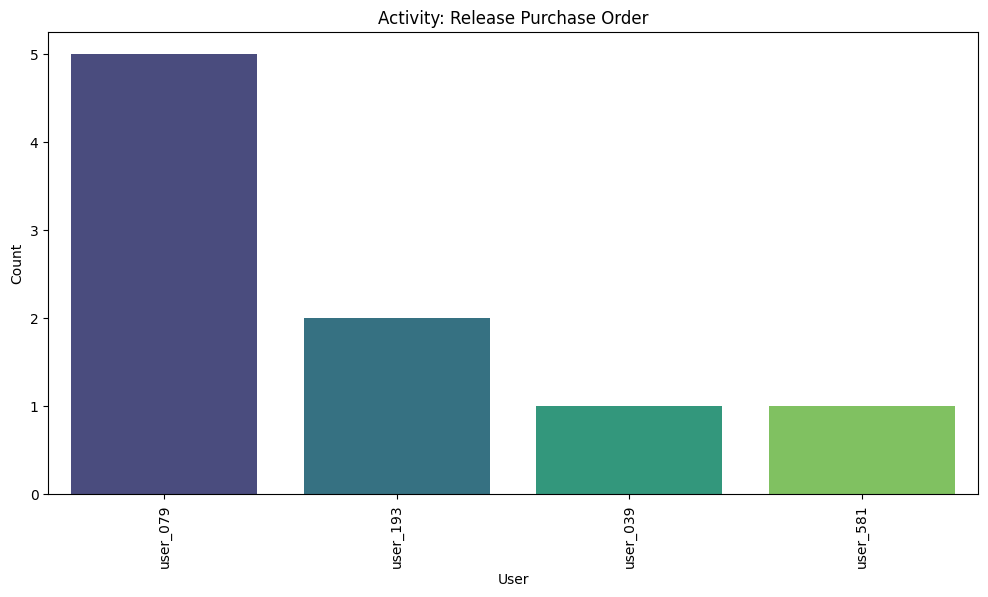

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1843093939.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


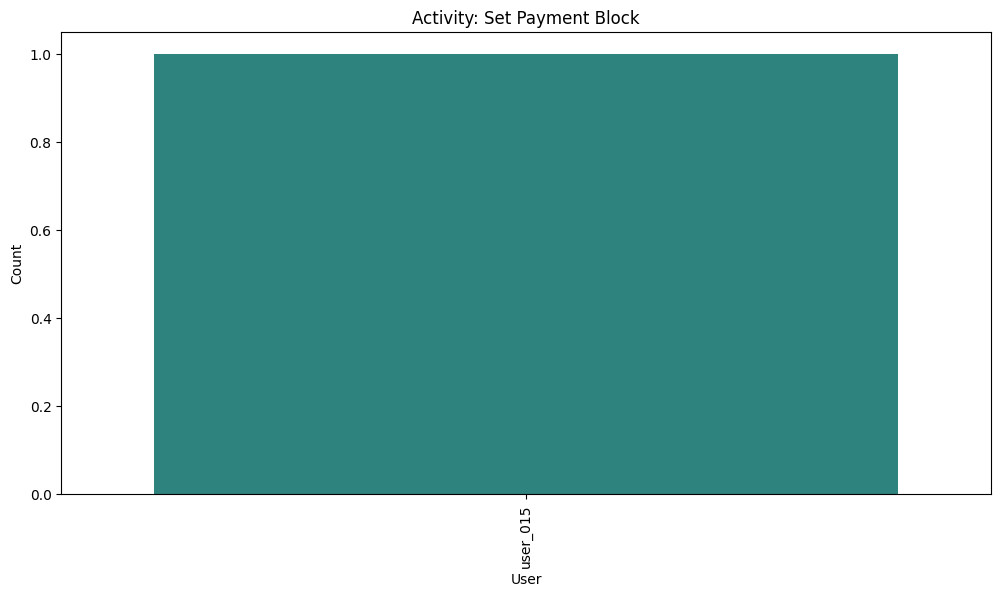

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1843093939.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


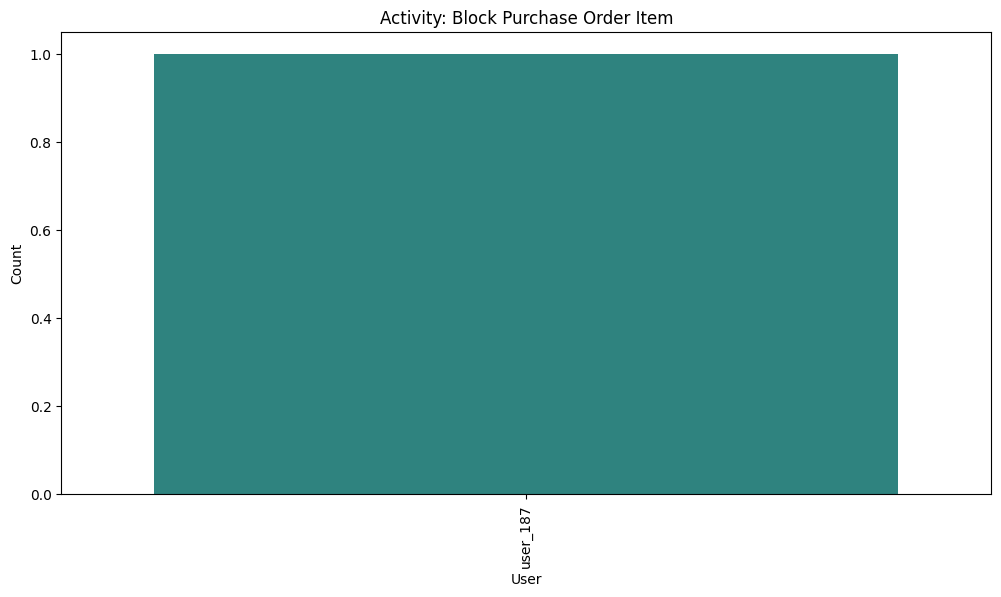

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1843093939.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


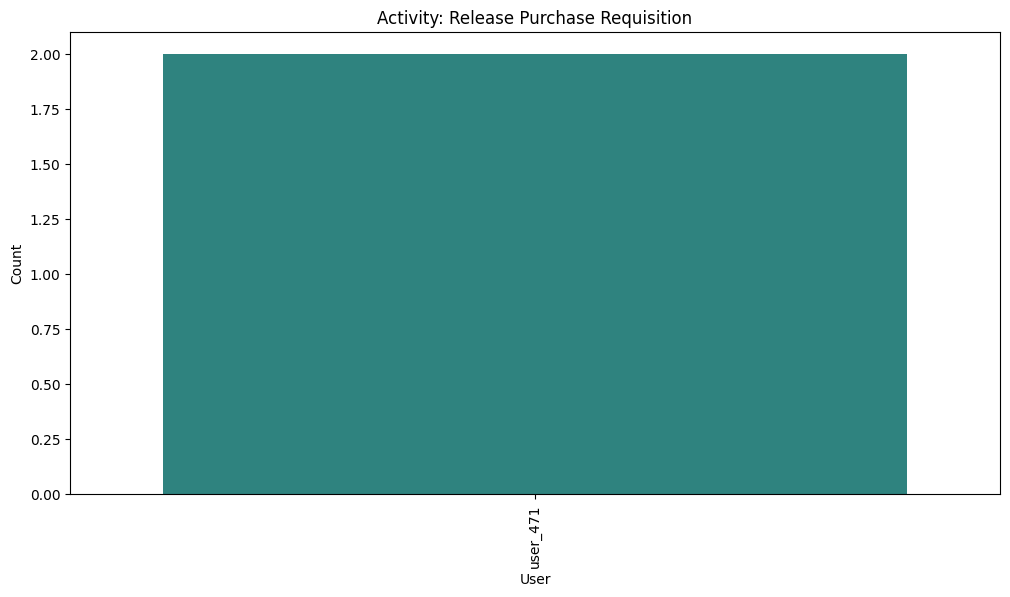

In [167]:
manual_activities_packaging = log[(~log["org:resource"].str.startswith("batch")) & (log["case:Spend area text"] == "Packaging")]

for activity in manual_activities_packaging["concept:name"].unique():
    activity_data = manual_activities_packaging[
        manual_activities_packaging["concept:name"] == activity
    ]
    user_counts = activity_data["org:resource"].value_counts()

    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=user_counts.index,
        y=user_counts.values,
        hue=user_counts.index,
        legend=False,
        palette="viridis",
    )
    plt.title(f'Activity: {activity}')
    plt.xlabel('User')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.show()

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


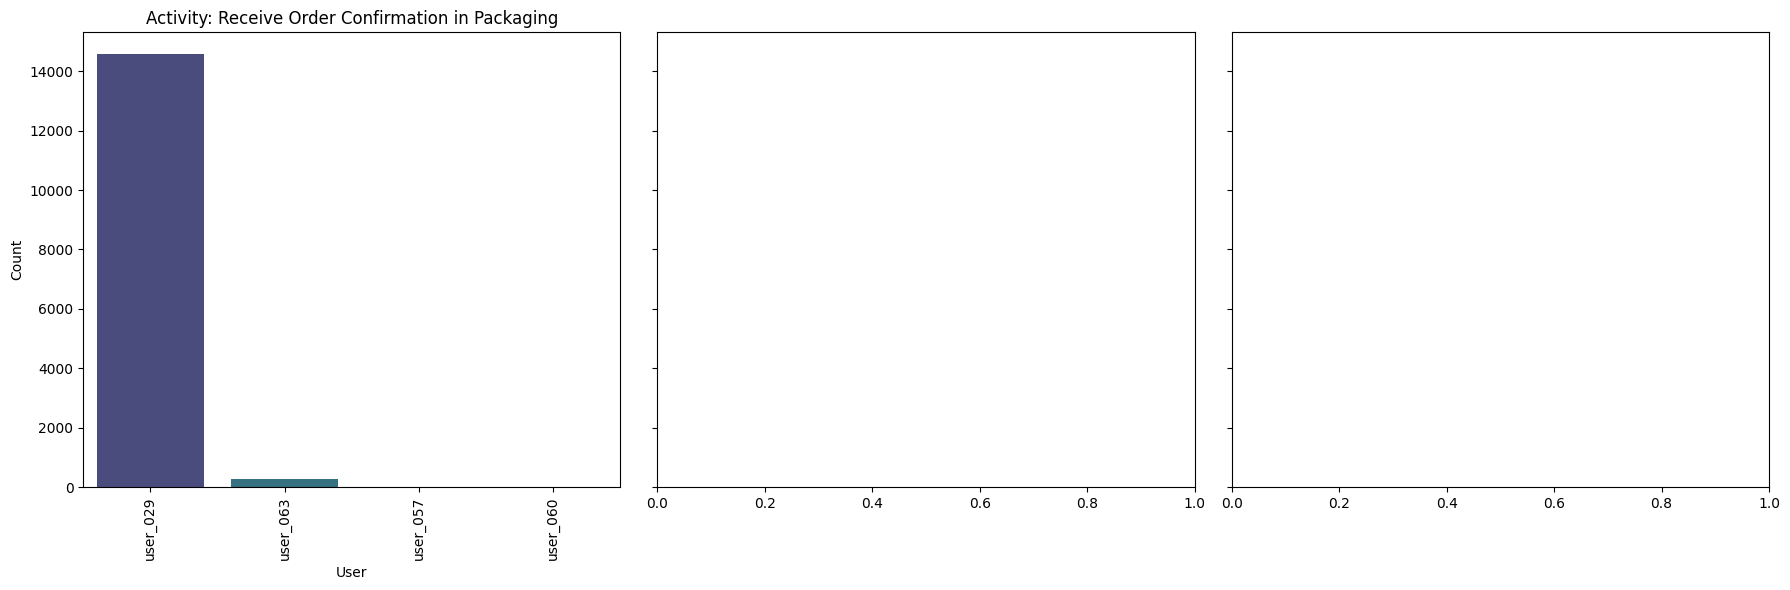

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\jojow\AppData\Local\Temp\ipykernel_3560\1043107580.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


<Figure size 640x480 with 0 Axes>

In [163]:
manual_activities = log[~log["org:resource"].str.startswith("batch")]

spend_areas = manual_activities["case:Spend area text"].unique()

fig, axes = plt.subplots(nrows=1, ncols=len(spend_areas), figsize=(18, 6), sharey=True)

for ax, spend_area in zip(axes, spend_areas):
    spend_area_data = manual_activities[manual_activities["case:Spend area text"] == spend_area]
    for activity in spend_area_data["concept:name"].unique():
        activity_data = spend_area_data[spend_area_data["concept:name"] == activity]
        user_counts = activity_data["org:resource"].value_counts()

        if user_counts.empty:
            print(f"Activity: {activity} in {spend_area} did not occur.")
        else:
            sns.barplot(
                x=user_counts.index,
                y=user_counts.values,
                palette="viridis",
                ax=ax
            )
            ax.set_title(f"Activity: {activity} in {spend_area}")
            ax.set_xlabel("User")
            ax.set_ylabel("Count")
            ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

            plt.tight_layout()
            plt.show()

In [ ]:
manual_activities = log[~log["org:resource"].str.startswith("batch")]
resource_activity_matrix = manual_activities.pivot_table(
    index="org:resource",
    columns="concept:name",
    aggfunc="size",
    fill_value=0,
)
print(resource_activity_matrix)
scaled_responsibilities = resource_activity_matrix.div(resource_activity_matrix.sum(axis=0), axis=1)
threshold = 1 / (scaled_responsibilities.shape[0] * 3)
filtered_responsibilities = scaled_responsibilities.where(
    scaled_responsibilities >= threshold, 0
)


print(filtered_responsibilities)

concept:name  Block Purchase Order Item  Cancel Goods Receipt  \
org:resource                                                    
user_001                              0                     0   
user_002                              0                     0   
user_004                              0                     0   
user_005                              0                     0   
user_006                              0                     0   
...                                 ...                   ...   
user_585                              0                     0   
user_589                              0                     0   
user_591                              0                     0   
user_593                              0                     0   
user_598                              0                     0   

concept:name  Cancel Invoice Receipt  Cancel Subsequent Invoice  \
org:resource                                                      
user_001            

PCA Loadings:
                                         PC1       PC2       PC3       PC4  \
concept:name                                                                 
Block Purchase Order Item           0.040021 -0.063291 -0.003454 -0.209330   
Cancel Goods Receipt               -0.001251  0.001968 -0.002056 -0.000542   
Cancel Invoice Receipt              0.045094 -0.124133 -0.003106  0.324675   
Cancel Subsequent Invoice           0.043240 -0.104597 -0.002466  0.232611   
Change Approval for Purchase Order  0.004342 -0.009757 -0.002823 -0.041786   
Change Currency                     0.058093 -0.073397  0.002095 -0.147554   
Change Delivery Indicator           0.003532 -0.004199 -0.002212 -0.022376   
Change Price                        0.003370 -0.005305 -0.002100 -0.020136   
Change Quantity                     0.010652 -0.016101 -0.002344 -0.053978   
Change Storage Location             0.010513 -0.011306 -0.001720 -0.030394   
Change payment term                 0.039648 -0.04

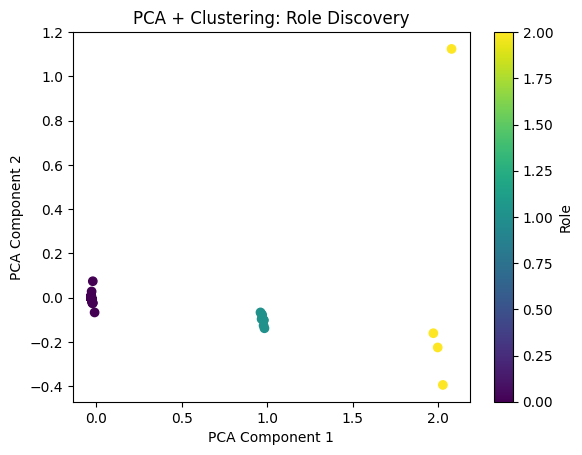

In [157]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Apply PCA
pca = PCA() 
pca_result = pca.fit_transform(filtered_responsibilities)

loadings = pd.DataFrame(
    pca.components_.T,  # Transpose so that rows correspond to original variables
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],  # Principal Component names
    index=filtered_responsibilities.columns,  # Original variable names
)

print("PCA Loadings:")
print(loadings)

# Step 2: Apply Clustering (K-Means)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(pca_result)

# Add cluster labels
filtered_responsibilities["role"] = kmeans.labels_

# Step 3: Visualize the Results
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans.labels_, cmap="viridis")
plt.title("PCA + Clustering: Role Discovery")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Role")
plt.show()

In [152]:
from sklearn.cluster import KMeans

# Normalize the matrix for clustering
normalized_matrix = filtered_responsibilities

# Apply K-Means clustering
kmeans = KMeans(n_clusters=10, random_state=42)  # Choose a reasonable number of clusters
kmeans.fit(normalized_matrix)

# Add role labels to the matrix
filtered_responsibilities["role"] = kmeans.labels_

grouped = filtered_responsibilities.groupby("role")

# Display activities done by users in each cluster
for role, group in grouped:
    print(f"Cluster {role}:")
    activities = group.drop(columns=["role"]).sum(axis=0)
    print("Activities done by users:")
    print(activities[activities > 0])
    print(f"Number of users in cluster: {group.shape[0]}")

Cluster 0:
Activities done by users:
concept:name
Cancel Invoice Receipt              0.000871
Change Price                        0.000785
Change Quantity                     0.002539
Create Purchase Order Item          0.002696
Create Purchase Requisition Item    0.045343
Delete Purchase Order Item          0.005859
Record Goods Receipt                0.016083
Record Invoice Receipt              0.002197
dtype: float64
Number of users in cluster: 260
Cluster 1:
Activities done by users:
concept:name
Block Purchase Order Item             0.003436
Cancel Goods Receipt                  1.000000
Cancel Invoice Receipt                0.253972
Cancel Subsequent Invoice             0.128806
Change Approval for Purchase Order    0.865355
Change Currency                       0.259259
Change Delivery Indicator             0.877702
Change Price                          0.899865
Change Quantity                       0.696672
Change Storage Location               0.713311
Clear Invoice          

In [138]:
manual_activities = log[~log["org:resource"].str.startswith("batch")]
log_other = manual_activities[manual_activities["case:Spend area text"] == "Other"]
log_packaging = manual_activities[
    manual_activities["case:Spend area text"] == "Packaging"
]
log_sales = manual_activities[manual_activities["case:Spend area text"] == "Sales"]

other_employees = log_other["org:resource"].unique()
packaging_employees = log_packaging["org:resource"].unique()
sales_employees = log_sales["org:resource"].unique()

only_other = set(other_employees) - set(packaging_employees) - set(sales_employees)
only_packaging = set(packaging_employees) - set(other_employees) - set(sales_employees)
only_sales = set(sales_employees) - set(other_employees) - set(packaging_employees)

print(len(only_other), len(only_packaging), len(only_sales))
print(len(manual_activities["org:resource"].unique()))

122 67 22
532


In [136]:
manual_activities = log[~log["org:resource"].str.startswith("batch")]
user_activity_spend_area_matrix = manual_activities.pivot_table(
    index="org:resource", 
    columns="concept:name", 
    values="case:Spend area text", 
    aggfunc=lambda x: len(x.unique()), 
    fill_value=0
)

# Count how often the value for an activity is greater than 1
activity_counts = (user_activity_spend_area_matrix > 1).sum(axis=0)
print(activity_counts)

single_spend_area_users = (user_activity_spend_area_matrix > 1).sum(axis=0)
print(activity_counts)
# List of users where all the entries are <= 1
users_all_entries_leq_1 = user_activity_spend_area_matrix[(user_activity_spend_area_matrix <= 1).all(axis=1)].index.tolist()
print("Users where all entries are <= 1:")
print(users_all_entries_leq_1)

concept:name
Block Purchase Order Item               1
Cancel Goods Receipt                   29
Cancel Invoice Receipt                 12
Cancel Subsequent Invoice               9
Change Approval for Purchase Order      9
Change Currency                         0
Change Delivery Indicator              46
Change Price                           51
Change Quantity                        94
Change Storage Location                 9
Change payment term                     0
Clear Invoice                          18
Create Purchase Order Item            108
Create Purchase Requisition Item       71
Delete Purchase Order Item             73
Reactivate Purchase Order Item         18
Receive Order Confirmation              4
Record Goods Receipt                  124
Record Invoice Receipt                 21
Record Subsequent Invoice               7
Release Purchase Order                  0
Release Purchase Requisition            0
Remove Payment Block                    9
Set Payment Block    

First we face the challenge of understanding distributions accross different activities and spendareas. In particular we aim to answer the questions, if certain activities are handled by users different users within different spendareas.

In [27]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load the data
data = pd.read_csv("normalized_data.csv", index_col=0)

# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data)

# Apply DBSCAN clustering
eps = 10  # Adjust the maximum distance between two samples for them to be considered as in the same neighborhood
min_samples = 100  # Adjust the number of samples in a neighborhood for a point to be considered as a core point
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(normalized_data)

# Add the cluster labels to the DataFrame
data["role"] = dbscan.labels_

# Print the resulting clusters
print(data)

# Group by cluster labels
grouped = data.groupby("role")

# Display activities done by users in each cluster
for role, group in grouped:
    print(f"Cluster {role}:")
    activities = group.drop(columns=["role"]).sum(axis=0)
    print("Activities done by users:")
    print(activities[activities > 0])
    print(f"Number of users in cluster: {group.shape[0]}")
    example_users = group.index.tolist()[:5]  # Show some example users
    print("Example users:", example_users)
    print("\n")

              Block Purchase Order Item  Cancel Goods Receipt  \
org:resource                                                    
NONE                                  0                     0   
batch_00                              0                     0   
batch_01                              0                     0   
batch_02                              0                     0   
batch_03                              0                     1   
...                                 ...                   ...   
user_585                              0                     0   
user_589                              0                     0   
user_591                              0                     0   
user_593                              0                     0   
user_598                              0                     0   

              Cancel Invoice Receipt  Cancel Subsequent Invoice  \
org:resource                                                      
NONE                

In [28]:
# Create a resource-activity matrix
import pandas as pd
resource_activity_matrix = log.pivot_table(
    index="org:resource", columns="concept:name", aggfunc=lambda x: 1 if len(x) > 0 else 0, fill_value=0
)
resource_activity_matrix
# Normalize the data
# scaler = StandardScaler()
# normalized_data = scaler.fit_transform(resource_activity_matrix)
# Save the normalized data to a CSV file in the current working directory
# normalized_df = pd.DataFrame(normalized_data, index=resource_activity_matrix.index, columns=resource_activity_matrix.columns)
#resource_activity_matrix.to_csv("normalized_data.csv", index=True)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=10, random_state=42)  # Adjust n_clusters as needed
kmeans.fit(resource_activity_matrix)

# Assign cluster labels
resource_activity_matrix["role"] = kmeans.labels_

# Print the resulting clusters
print(resource_activity_matrix)

# Group by cluster labels
grouped = resource_activity_matrix.groupby("role")

# Display activities done by users in each cluster
for role, group in grouped:
    print(f"Cluster {role}:")
    activities = group.drop(columns=["role"]).sum(axis=0)
    print("Activities done by users:")
    print(activities[activities > 0])
    print(f"Number of users in cluster: {group.shape[0]}")
    example_users = group.index.tolist()[:5]  # Show some example users
    print("Example users:", example_users)
    print("\n")

             Cumulative net worth (EUR)                       \
concept:name  Block Purchase Order Item Cancel Goods Receipt   
org:resource                                                   
NONE                                  0                    0   
batch_00                              0                    0   
batch_01                              0                    0   
batch_02                              0                    0   
batch_03                              0                    1   
...                                 ...                  ...   
user_585                              0                    0   
user_589                              0                    0   
user_591                              0                    0   
user_593                              0                    0   
user_598                              0                    0   

                                                               \
concept:name Cancel Invoice Receipt Ca

concept:name  Block Purchase Order Item  Cancel Goods Receipt  \
org:resource                                                    
NONE                                  0                     0   
batch_00                              0                     0   
batch_01                              0                     0   
batch_02                              0                     0   
batch_03                              0                     1   
...                                 ...                   ...   
user_585                              0                     0   
user_589                              0                     0   
user_591                              0                     0   
user_593                              0                     0   
user_598                              0                     0   

concept:name  Cancel Invoice Receipt  Cancel Subsequent Invoice  \
org:resource                                                      
NONE                

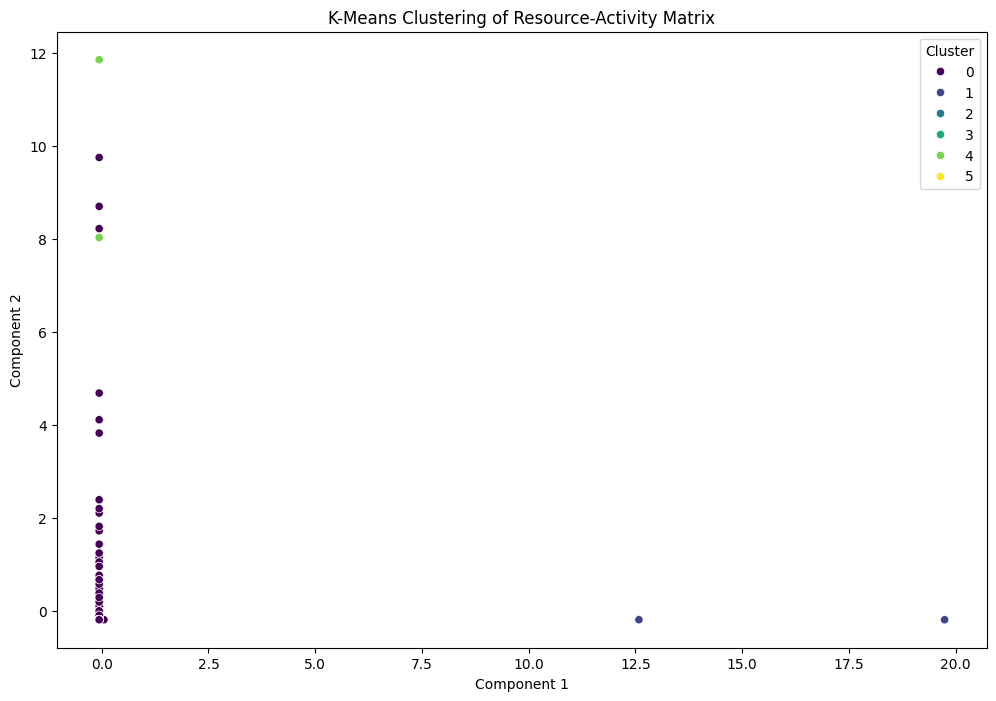

In [7]:
# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(resource_activity_matrix)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=6, random_state=42)  # Adjust n_clusters as needed
kmeans.fit(normalized_data)

# Assign cluster labels
resource_activity_matrix["role"] = kmeans.labels_

# Print the resulting clusters
print(resource_activity_matrix)

In [ ]:
for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(normalized_data)
    silhouette_avg = silhouette_score(normalized_data, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the Silhouette Score is {silhouette_avg}")

In [6]:
print(log["org:resource"].unique())

['batch_00' 'user_000' 'NONE' 'user_001' 'user_002' 'user_004' 'user_005'
 'user_003' 'user_006' 'user_007' 'user_008' 'user_011' 'user_009'
 'user_010' 'user_012' 'user_013' 'user_014' 'user_015' 'user_018'
 'user_016' 'user_019' 'user_017' 'user_020' 'user_021' 'batch_01'
 'user_022' 'user_023' 'user_024' 'user_025' 'user_026' 'batch_02'
 'user_027' 'user_028' 'batch_03' 'user_029' 'user_030' 'batch_04'
 'user_031' 'user_032' 'user_033' 'user_034' 'user_035' 'user_036'
 'user_037' 'user_038' 'user_039' 'user_040' 'user_041' 'user_042'
 'user_043' 'user_044' 'user_045' 'user_046' 'user_047' 'user_048'
 'user_049' 'user_050' 'user_051' 'batch_05' 'user_052' 'user_053'
 'user_054' 'user_055' 'user_056' 'user_057' 'user_058' 'user_059'
 'user_060' 'user_061' 'user_062' 'user_063' 'user_064' 'user_065'
 'user_066' 'user_067' 'user_068' 'user_069' 'user_070' 'user_071'
 'user_072' 'batch_06' 'user_073' 'user_074' 'user_075' 'user_076'
 'user_077' 'user_078' 'user_079' 'user_080' 'user_081'

**Question 1:** Are there users doing the same task for different spend areas? If so, for which? 

**Question 2:** What events are done by the same users? Creating roles. How many users per role?